In [121]:
import pandas as pd

import sys
sys.path.append('/Users/basileroth/Desktop/Code/offseason_greenlobby/')
from offseason_greenlobby.config import color_16

import numpy as np
from offseason_greenlobby.utils.utils import get_surrounding_words,extract_until_period,clean_text,get_gp_senat
# define subplot grid
import matplotlib.pyplot as plt 
import re

# Travail pour la Loi d'orientation pour la souveraineté alimentaire et le renouvellement des générations en agriculture

### Assemblée nationale

- AN: 5415
- AN Comission affaires économiques: 3596
- AN Commission affaires culturelles et éducation: 296
- AN Commission DD et aménagement territoire: 793




In [122]:
df_an = pd.read_csv("/Users/basileroth/Desktop/Code/offseason_greenlobby/data/processed/LOA/AN/df_an.csv")
df_an.dropna(subset=["expose_sommaire"],inplace=True)
df_an.shape

(7023, 14)

In [123]:
df_an['color'] = df_an['groupe_politique_nom'].apply(lambda x : color_16.get(x,{"couleur":"grey"}).get("couleur","grey"))

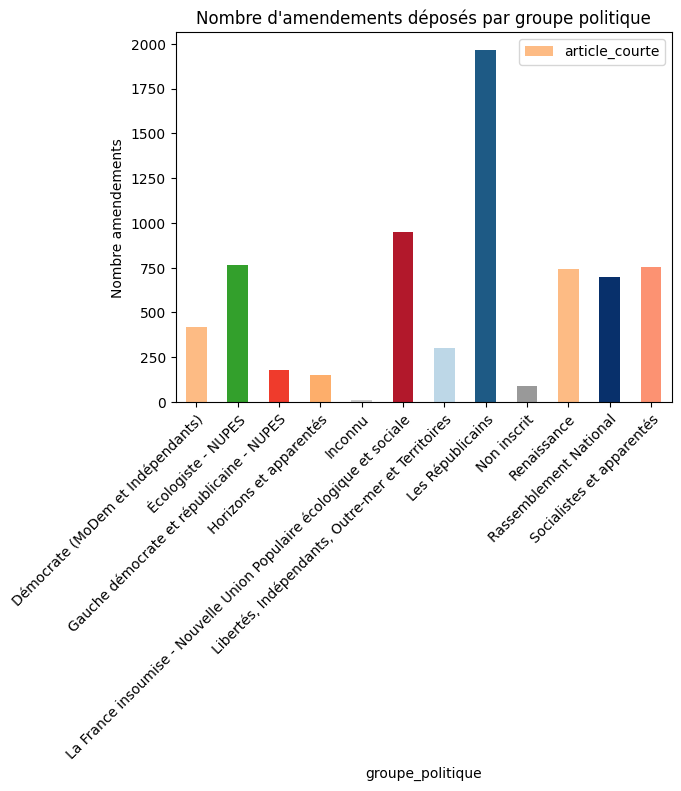

In [124]:
bar_plot_df = df_an.groupby(["groupe_politique","groupe_politique_nom","color"]).article_courte.count().reset_index()

ax = bar_plot_df.plot.bar(x='groupe_politique', y='article_courte', rot=0,color=bar_plot_df.color.values)

ax.set_title("Nombre d'amendements déposés par groupe politique")
ax.set_ylabel("Nombre amendements")
ax.set_xticklabels(df_an.groupby(["groupe_politique","groupe_politique_nom"]).article_courte.count().reset_index().groupe_politique_nom, rotation=45, ha='right', rotation_mode='anchor')

plt.show();

### Sénat

In [125]:
df_senat_total = pd.read_csv("/Users/basileroth/Desktop/Code/offseason_greenlobby/data/processed/LOA/SENAT/df_senat.csv",index_col=0)

## FNSEA

In [126]:
df_fnsea = pd.read_excel('/Users/basileroth/Desktop/Code/offseason_greenlobby/data/raw/Amendements_FNSEA_souveraineté.xlsx')

df_fnsea["article original"] = df_fnsea["article concerné"].apply(lambda x : 1 if "PREMIER" in x else int(''.join(filter(str.isdigit, x))))
df_fnsea["num_amendements_art_an"] = df_fnsea["article original"].apply(lambda x : df_an[df_an['article'] == x].shape[0])
df_fnsea["num_amendements_art_senat"] = df_fnsea["article original"].apply(lambda x : df_senat_total[df_senat_total['article'] == x].shape[0])

df_fnsea["num_amendements_art_an_part"] = df_fnsea["article concerné"].apply(lambda x : df_an[df_an['article_courte'] == x].shape[0])

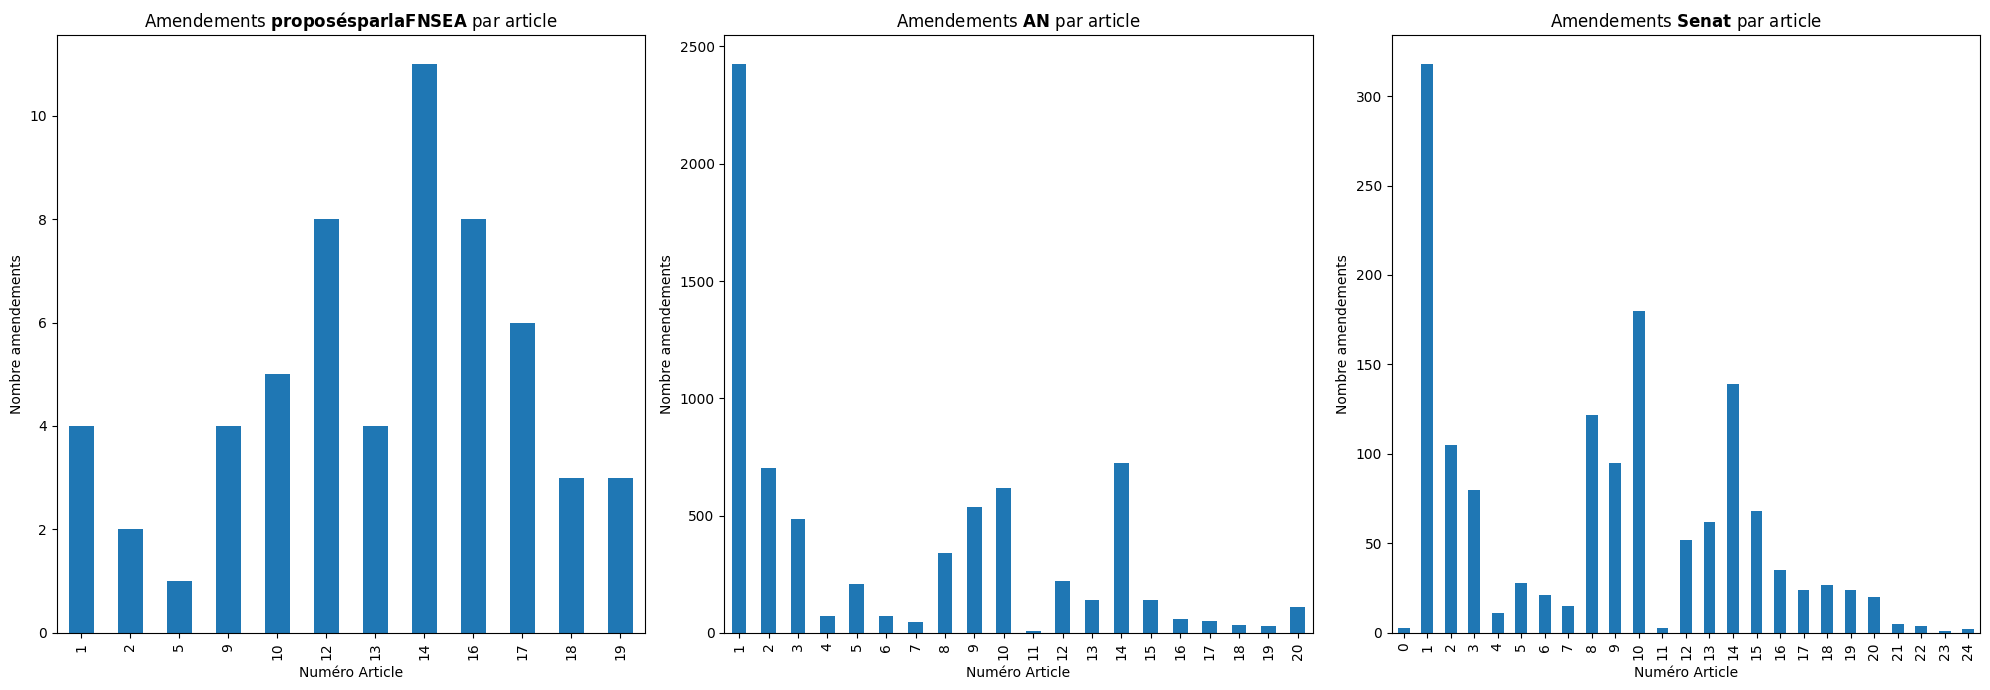

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

df_fnsea['article original'].value_counts().sort_index().plot(kind = 'bar',ax=axs[0]);
axs[0].set_ylabel('Nombre amendements')
axs[0].set_xlabel('Numéro Article')
axs[0].set_title('Amendements '  + r"$\bf{" + "proposés par la FNSEA " + "}$ "+ 'par article');


"""
# Regrouper par 'Catégorie' et 'Sous-catégorie', puis sommer les valeurs
grouped = df_an.groupby(['article', 'groupe_politique_nom']).agg({
    "color":"min",
    "expose_sommaire":"count"
}).unstack(fill_value=0)

# 'expose_sommaire'].count().unstack(fill_value=0)
# Tracer le diagramme à barres empilées
grouped.plot(kind='bar', stacked=True,ax=axs[1])
"""

df_an.article.value_counts().sort_index().plot(kind ='bar',ax=axs[1]);
axs[1].set_ylabel('Nombre amendements')
axs[1].set_xlabel('Numéro Article')
axs[1].set_title('Amendements '  + r"$\bf{" + "AN " + "}$ "+ 'par article');


df_senat_total.article.value_counts().sort_index().plot(kind ='bar',ax=axs[2]);
axs[2].set_ylabel('Nombre amendements')
axs[2].set_xlabel('Numéro Article')
axs[2].set_title('Amendements '  + r"$\bf{" + "Senat " + "}$ "+ 'par article');

fig.tight_layout();

# Check linkedin

### 1. Plus de 3 500 amendements ont été déposés en vue de l'examen de la proposition de loi dite « Duplomb » en séance publique à l' Assemblée nationale.

In [13]:
df_ann = pd.read_csv("/Users/basileroth/Desktop/Code/offseason_greenlobby/data/processed/LOA/AN/df_an.csv")
print(f"Amendements en séance publique à l'AN : {df_an[df_an.type_amendement == "AN"].shape[0]} (avec exposé des motifs) ✅")
print(f"{df_ann[df_ann.type_amendement == "AN"].shape[0]} sinon.")


Amendements en séance publique à l'AN : 3867 (avec exposé des motifs) ✅
5415 sinon.


### 2. 👉37 mentionnent explicitement la FNSEA comme co-auteur ou source directe


In [14]:
df_an["contains_FNSEA"] = df_an["expose_sommaire"].str.lower().apply(lambda x : True if ("FNSEA" in x) or ("fnsea" in x) or ("fédération nationale des syndicats d'exploitants agricoles" in x) else False)

print(df_an.contains_FNSEA.value_counts())
print("❌")

contains_FNSEA
False    6884
True      139
Name: count, dtype: int64
❌


In [15]:
import re

def get_context_around(text, substring, window=10):
    # Tokenize text into words
    words = re.findall(r'\w+|\S\w*', text)  # keeps punctuation as separate tokens
    
    # Reconstruct text from word list to locate word index by character position
    joined_text = ' '.join(words)
    match = re.search(re.escape(substring), joined_text)

    if not match:
        return None  # substring not found

    # Count words before the match start
    start_char = match.start()
    char_count = 0
    word_index = 0
    for i, word in enumerate(words):
        char_count += len(word) + 1  # +1 for the space
        if char_count > start_char:
            word_index = i
            break

    # Compute bounds safely
    start = max(0, word_index - window)
    end = min(len(words), word_index + window + 1)

    return words[start:word_index], words[word_index], words[word_index+1:end]

for index,row in df_an[df_an.contains_FNSEA == True].iterrows():
    print(row["expose_sommaire"])
    before, target_word, after = get_context_around(row["expose_sommaire"], "FNSEA")
    print("Before:", ' '.join(before))
    print("Target:", target_word)
    print("After:",  ' '.join(after))


Cet amendement proposé par la FNSEA reformule le principe sans en changer la signification. Il traduit juridiquement la volonté politique de rééquilibrer les intérêts agricoles et intérêts environnementaux. Il vise à inscrire le principe fondamental selon lequel la protection, la valorisation et le déploiement de l’agriculture sont reconnus d’intérêt général majeur et défendus au même titre que les autres intérêts fondamentaux de la Nation.A noter que l’actuel dispositif législatif figurant à l’article L. 1 du code rural et de la pêche maritime détaille précisément les principes de la politique en faveur de l’agriculture et de l’alimentation et notamment qu’elle vise à sauvegarder voire à reconquérir la souveraineté alimentaire.
Before: Cet amendement proposé par la
Target: FNSEA
After: reformule le principe sans en changer la signification . Il
Face au déclin inquiétant du secteur de l’élevage en France et aux menaces qu'il fait peser sur la souveraineté agricole dans les productions 

TypeError: cannot unpack non-iterable NoneType object

### 3. 👉18 sont des copiés-collés quasi intégraux d’une liasse technique transmise par le syndicat



### 4. 👉 Plus de 150 amendements s’en inspirent directement, en reprenant formulations, objectifs ou éléments de langage.


# Recherche influence FNSEA dans amendements

1. Recherche des mots **FNSEA** ou **Fédération Nationale des Syndicats d'Exploitants Agricoles**

In [16]:
df_an["contains_FNSEA"] = df_an["expose_sommaire"].str.lower().apply(lambda x : True if ("FNSEA" in x) or ("fnsea" in x) or ("fédération nationale des syndicats d'exploitants agricoles" in x) else False)

In [17]:
df_an.contains_FNSEA.value_counts()

contains_FNSEA
False    6884
True      139
Name: count, dtype: int64

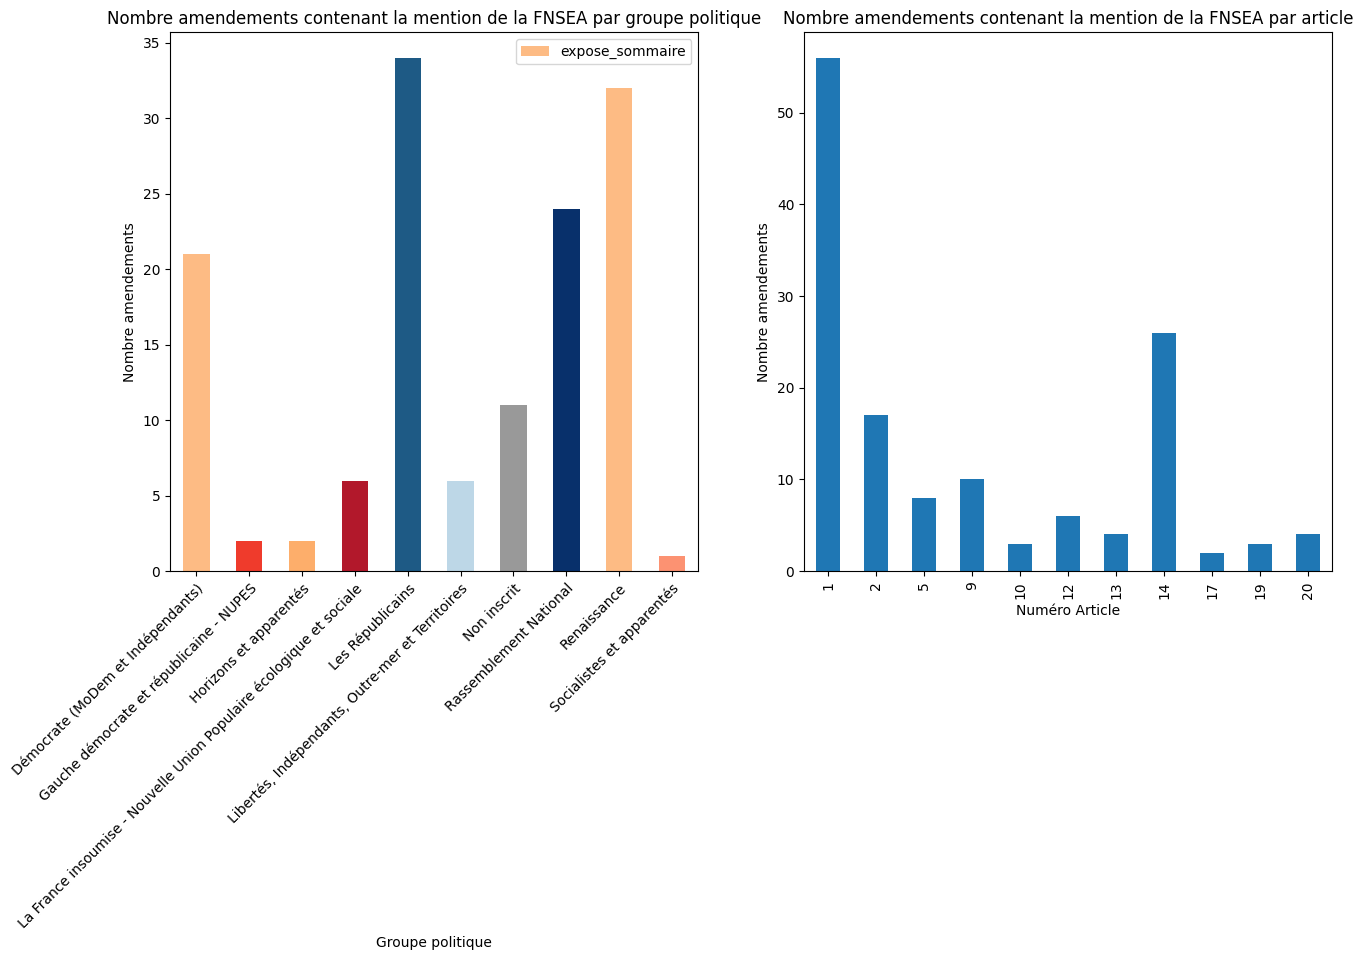

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

df = df_an[df_an["contains_FNSEA"] == True].groupby(["groupe_politique_nom","color"]).expose_sommaire.count().reset_index()

df.plot.bar(x='groupe_politique_nom', y='expose_sommaire', rot=0, ax = axs[0], color=df.color.values)
axs[0].set_xticklabels(df.groupe_politique_nom, rotation=45, ha='right', rotation_mode='anchor')
axs[0].set_title("Nombre amendements contenant la mention de la FNSEA par groupe politique");
axs[0].set_xlabel("Groupe politique");
axs[0].set_ylabel("Nombre amendements");

df_an[df_an["contains_FNSEA"] == True].article.value_counts().sort_index().plot(kind ='bar',ax=axs[1]);
axs[1].set_ylabel('Nombre amendements')
axs[1].set_xlabel('Numéro Article')
axs[1].set_title("Nombre amendements contenant la mention de la FNSEA par article");


# Identification des éléments de languages permettant de voir avec quel organisations les amendements ont été travaillés.

In [19]:
str_influence_lobbys = [
    "amendement est proposé par",
    "amendement a été proposé par",
    "amendement est proposé en concertation avec",
    "proposé ici par",
    "amendement proposé par",    
    "amendement a été travaillé avec",
    "amendement travaillé avec",
    "amendement travaillé en coopération avec"
    "amendement travaillé",
    "travaillé avec",
    "élaboré avec",
    "a été travaillé avec",
    "travaillé en coopération avec",
    "amendement a été co-construit en collaboration avec",
    "a été rédigé en collaboration avec",
    "rédigé en collaboration avec",
    "amendement a été rédigé en collaboration avec",
    "amendement rédigé en collaboration",
    "amendement est issu d'une proposition de",
    "inspiré de l'une des propositions de"
    ]

In [20]:
def matcher(x):
    for i in str_influence_lobbys:
        if i.lower() in x.lower():
            return i
    else:
        return np.nan

df_an['Match'] = df_an.expose_sommaire.apply(matcher)
df_lobbys = df_an.dropna(subset=['Match']).copy()
df_lobbys['Match_Str'] = df_lobbys.apply(lambda x : extract_until_period(x['expose_sommaire'], x['Match']), axis=1)

### Transformers

In [21]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained(
    "Jean-Baptiste/camembert-ner")

model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

/Users/basileroth/Desktop/Code/offseason_greenlobby/gl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
nlp_tf = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

Device set to use mps:0


#### COMPARE

In [24]:
orgs = []

for phrase in df_lobbys['Match_Str']:
    # TRANSFORMERS
    entities = nlp_tf(phrase)
    orgs_tf = [ent['word'] for ent in entities if ent['entity_group'] == "ORG"]
    orgs.extend(orgs_tf)

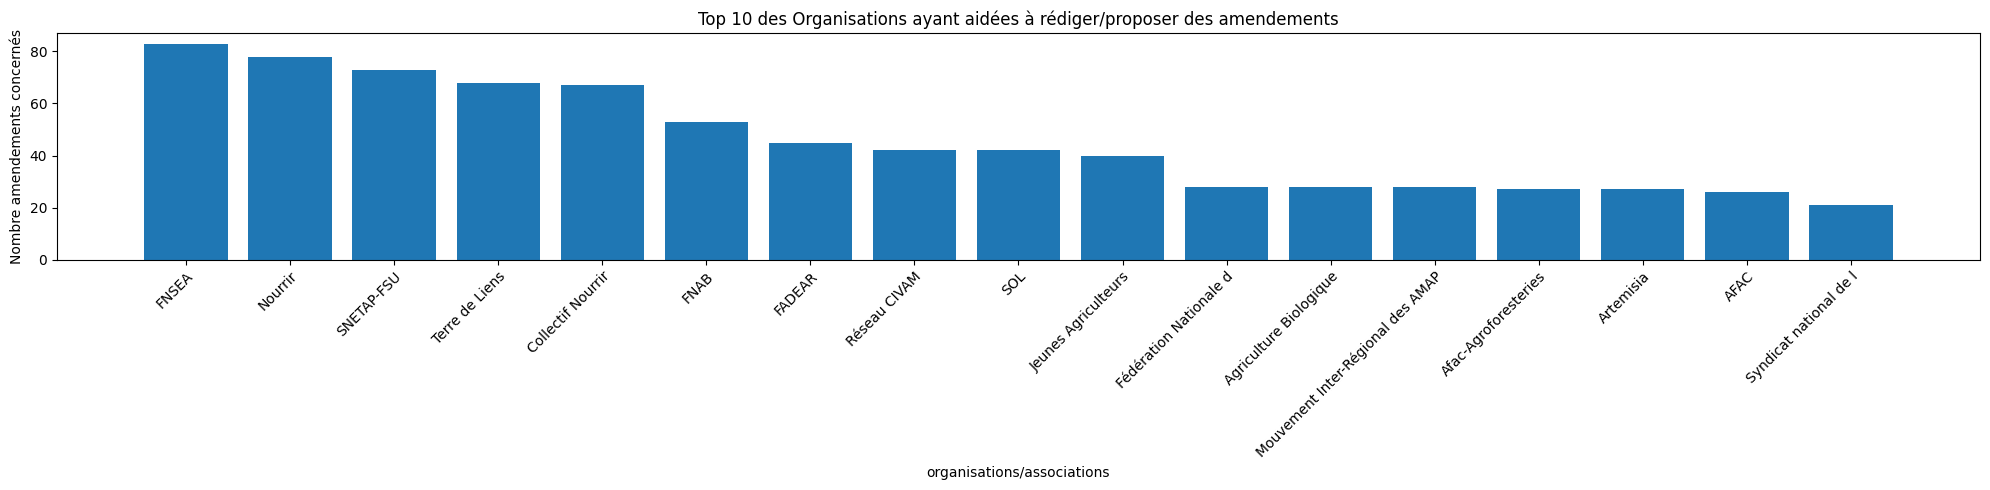

In [31]:
from collections import Counter
from itertools import islice


n = 17

count_dict = Counter(orgs)

# Sort the dictionary by values in descending order
sorted_items = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)

# Take the first 10 elements
top_10_items = sorted_items[:n]
keys, values = zip(*top_10_items)

# Create bar plot
plt.figure(figsize=(20, 5))
plt.bar(keys, values)
plt.ylabel('Nombre amendements concernés')
plt.xlabel('organisations/associations')
plt.title('Top 10 des Organisations ayant aidées à rédiger/proposer des amendements')
plt.xticks(keys, rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show()

# Recherche par comparaison d'embeddings - AN

In [128]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle multilingue
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [131]:
df_fnsea["expose_embed"] = df_fnsea["exposé des motifs"].apply(lambda x : model.encode(x))
df_fnsea["dispositif_embed"] = df_fnsea["dispositif"].apply(lambda x : model.encode(x))

In [134]:
df_an["expose_embed"] = df_an["expose_sommaire"].apply(lambda x : model.encode(x))
df_an["dispositif_embed"] = df_an["dispositif"].apply(lambda x : model.encode(x))

In [164]:
THRESHOLD = 0.90

In [165]:
# CALCUL DU NOMBRE D'AMENDEMENTS DE L'ASSEMBLEE QUI CORRESPONDENT PAR RAPPORT À CEUX DE LA FNSEA
def get_list_amendements_exposé(article,exposé,THRESHOLD):
    exp_cpt = df_an[df_an['article_courte'] == article].expose_embed.apply(lambda x : 1 if util.cos_sim(x, exposé)[0][0] > THRESHOLD else False)
    return exp_cpt.sum()

def get_list_amendements_dispositif(article,dispositf,THRESHOLD):
    exp_cpt = df_an[df_an['article_courte'] == article].dispositif_embed.apply(lambda x : 1 if util.cos_sim(x, dispositf)[0][0] > THRESHOLD else False)
    return exp_cpt.sum()

df_fnsea['expose_cpt'] = df_fnsea.apply(lambda x: get_list_amendements_exposé(x['article concerné'], x["expose_embed"],  THRESHOLD), axis=1)
df_fnsea['dispositif_cpt'] = df_fnsea.apply(lambda x: get_list_amendements_dispositif(x['article concerné'], x["dispositif_embed"], THRESHOLD), axis=1)

df_fnsea['expose_cpt_original'] = df_fnsea.apply(lambda x: get_list_amendements_exposé(x['article original'], x["expose_embed"],  THRESHOLD), axis=1)
df_fnsea['dispositif_cpt_original'] = df_fnsea.apply(lambda x: get_list_amendements_dispositif(x['article original'], x["dispositif_embed"], THRESHOLD), axis=1)

# Idées les plus reprises

In [211]:
bar_plot_df = df_fnsea.sort_values("expose_cpt")["exposé des motifs"].head(10).values

bar_plot_df

array(['Le présent amendement propose de simplifier et de mieux cibler l’application du dispositif de\ncontrôle des mouvements de parts sociales de sociétés détenant ou exploitant du foncier à usage ou\nà vocation agricole crée par la loi n°2021-1756 du 23 décembre 2021. Il propose ainsi de ne pas tenir\ncompte des coefficients d’équivalence concernant les élevages ou productions végétales hors-sol qui\naboutissent à soumettre au contrôle des personnes détenant ou exploitant de tels biens alors même\nque les surfaces cadastrales qu’elles détiennent ou exploitent sont faibles. Dès lors, contrôler de\ntelles exploitations n’entre pas dans les objectifs du nouveau dispositif, lequel a pour vocation à ne\nconcerner que les exploitations de taille importante aboutissant à porter préjudice à l’installation des\njeunes.',
       'Le présent amendement propose de simplifier l’application du dispositif de contrôle des mouvements\nde parts sociales de sociétés détenant ou exploitant du foncier à

In [212]:
def get_cpt_per_amendement_exp(article,exposé,THRESHOLD):
    exp_cpt = df_fnsea[df_fnsea['article concerné'] == article].expose_embed.apply(lambda x : 1 if util.cos_sim(x, exposé)[0][0] > THRESHOLD else False)
    return 1 if exp_cpt.sum() > 0 else 0

def get_cpt_per_amendement_disp(article,dispositf,THRESHOLD):
    exp_cpt = df_fnsea[df_fnsea['article concerné'] == article].dispositif_embed.apply(lambda x : 1 if util.cos_sim(x, dispositf)[0][0] > THRESHOLD else False)
    return 1 if exp_cpt.sum() > 0 else 0

df_an['expose_fnsea'] = df_an.apply(lambda x: get_cpt_per_amendement_exp(x['article_courte'], x["expose_embed"], THRESHOLD), axis=1)
df_an['dispositif_fnsea'] = df_an.apply(lambda x: get_cpt_per_amendement_disp(x['article_courte'], x["dispositif_embed"], THRESHOLD), axis=1)

def get_cpt_per_amendement_exp_full(article,exposé,THRESHOLD):
    exp_cpt = df_fnsea[df_fnsea['article concerné'] == article].expose_embed.apply(lambda x : 1 if util.cos_sim(x, exposé)[0][0] > THRESHOLD else False)
    return exp_cpt.sum()

def get_cpt_per_amendement_disp_full(article,dispositf,THRESHOLD):
    exp_cpt = df_fnsea[df_fnsea['article concerné'] == article].dispositif_embed.apply(lambda x : 1 if util.cos_sim(x, dispositf)[0][0] > THRESHOLD else False)
    return exp_cpt.sum()

df_an['expose_fnsea_full'] = df_an.apply(lambda x: get_cpt_per_amendement_exp_full(x['article_courte'], x["expose_embed"], THRESHOLD), axis=1)
df_an['dispositif_fnsea_full'] = df_an.apply(lambda x: get_cpt_per_amendement_disp_full(x['article_courte'], x["dispositif_embed"], THRESHOLD), axis=1)

# % Amendements co-rédigé par la FNSEA par article

In [ ]:
res = []

for index,row in df_an.iterrows():
    res.extend(df_fnsea[df_fnsea['article concerné'] == row["article_courte"]].expose_embed.apply(lambda x : util.cos_sim(x, row["expose_embed"])[0][0]).values)

    # for i,r in df_fnsea.iterrows():
    #    res.append(util.cos_sim(row["expose_embed"], r["expose_embed"])[0][0])

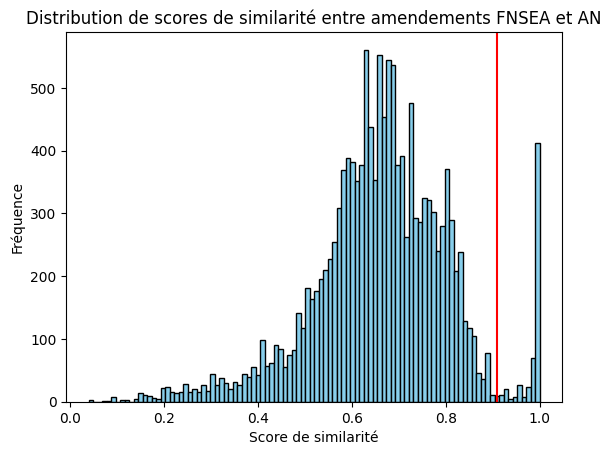

In [224]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data for the histogram
data = res

# Plotting a basic histogram
plt.hist(data, bins=100, color='skyblue', edgecolor='black')

plt.axvline(x = 0.91, color = 'r', label = 'axvline - full height')


# Adding labels and title
plt.xlabel('Score de similarité')
plt.ylabel('Fréquence')
plt.title('Distribution de scores de similarité entre amendements FNSEA et AN')

# Display the plot
plt.show()

In [168]:
an = df_an.groupby(["article_courte"]).agg({
    'expose_fnsea': 'sum' } ).reset_index().rename(columns={"article_courte":"article concerné"})

fnsea = df_fnsea[["article concerné","num_amendements_art_an_part"]].groupby("article concerné").num_amendements_art_an_part.mean().reset_index()

for index,row in an.iterrows():
    fnsea.loc[fnsea["article concerné"] == row["article concerné"],"cpt"] = row["expose_fnsea"]

fnsea["pct_concerné"] = fnsea["cpt"] / fnsea["num_amendements_art_an_part"] * 100

In [169]:
fnsea

,article concerné,num_amendements_art_an_part,cpt,pct_concerné
0,APRÈS ART. 10,50.0,7.0,14.000000
1,APRÈS ART. 12,76.0,3.0,3.947368
2,APRÈS ART. 16,9.0,0.0,0.000000
3,APRÈS ART. 17,17.0,5.0,29.411765
4,APRÈS ART. 18,11.0,0.0,0.000000
5,APRÈS ART. 19,21.0,2.0,9.523810
6,APRÈS ART. 9,12.0,1.0,8.333333
7,APRÈS ART. PREMIER,266.0,90.0,33.834586
8,ART. 10,554.0,12.0,2.166065
9,ART. 12,136.0,10.0,7.352941


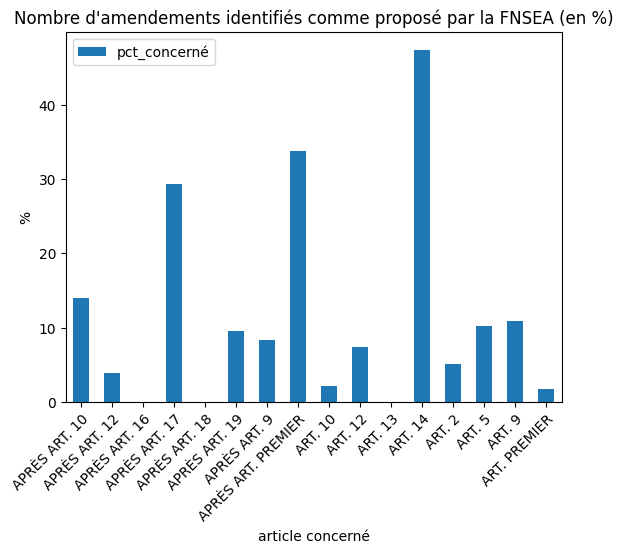

In [170]:
ax = fnsea.plot(x="article concerné", y=["pct_concerné"], kind="bar", rot=0)
ax.set_title("Nombre d'amendements identifiés comme proposé par la FNSEA (en %)")
ax.set_xticklabels(fnsea["article concerné"], rotation=45, rotation_mode='anchor' ,ha='right')
ax.set_ylabel("%")
fig.tight_layout();
plt.show();

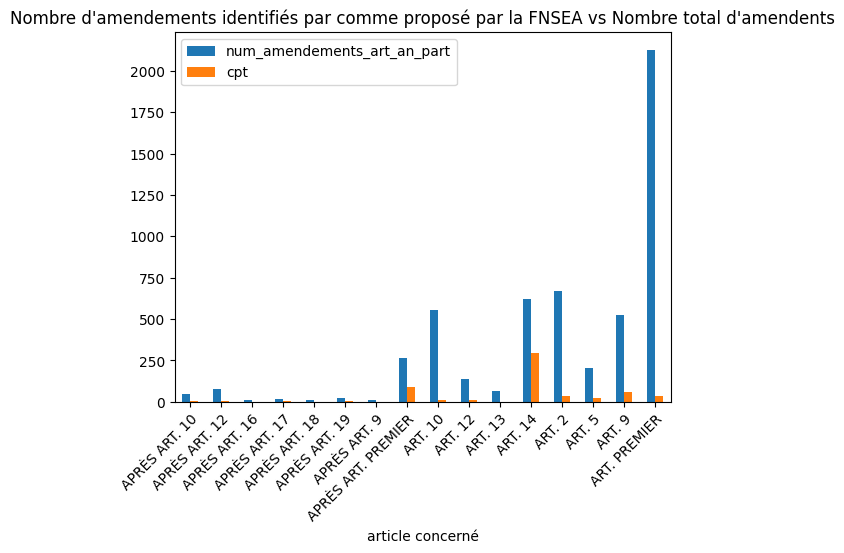

In [171]:
ax = fnsea.plot(x="article concerné", y=["num_amendements_art_an_part", "cpt"], kind="bar", rot=0)
ax.set_title("Nombre d'amendements identifiés par comme proposé par la FNSEA vs Nombre total d'amendents")
ax.set_xticklabels(fnsea["article concerné"], rotation=45, rotation_mode='anchor' ,ha='right')
fig.tight_layout();
plt.show();

# Nombre par GP et par député

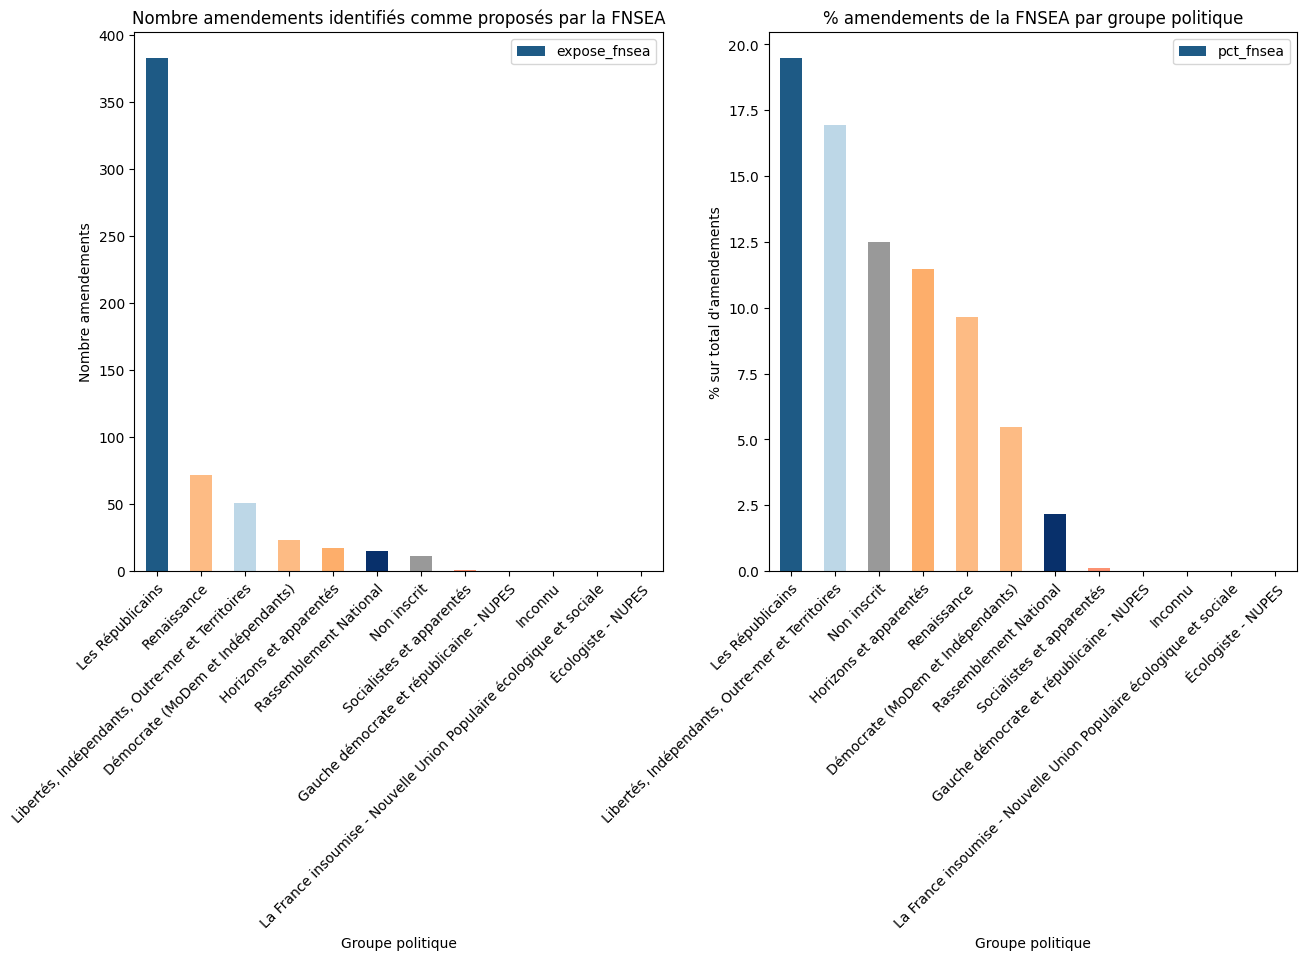

In [192]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

df = df_an.groupby(["groupe_politique_nom"]).agg({
    "expose_fnsea" : "sum",
    "color" : "max"
}).reset_index().sort_values("expose_fnsea",ascending=False)

df.plot.bar(x='groupe_politique_nom', y='expose_fnsea', rot=0, ax = axs[0], color=df.color.values)
axs[0].set_xticklabels(df.groupe_politique_nom, rotation=45, ha='right', rotation_mode='anchor')
axs[0].set_title("Nombre amendements identifiés comme proposés par la FNSEA");
axs[0].set_xlabel("Groupe politique");
axs[0].set_ylabel("Nombre amendements");


df = df_an.groupby(["groupe_politique_nom"]).agg({
    "expose_fnsea" : "sum",
    "article" : "count",
    "color" : "max"
}).reset_index()

df["pct_fnsea"] = df["expose_fnsea"] * 100 /  df["article"] 

df = df.sort_values("pct_fnsea",ascending=False)

df.plot.bar(x='groupe_politique_nom', y='pct_fnsea', rot=0, ax = axs[1], color=df.color.values)
axs[1].set_xticklabels(df.groupe_politique_nom, rotation=45, ha='right', rotation_mode='anchor')
axs[1].set_title("% amendements de la FNSEA par groupe politique")
axs[1].set_xlabel("Groupe politique");
axs[1].set_ylabel("% sur total d'amendements");

# % Par GP et par député

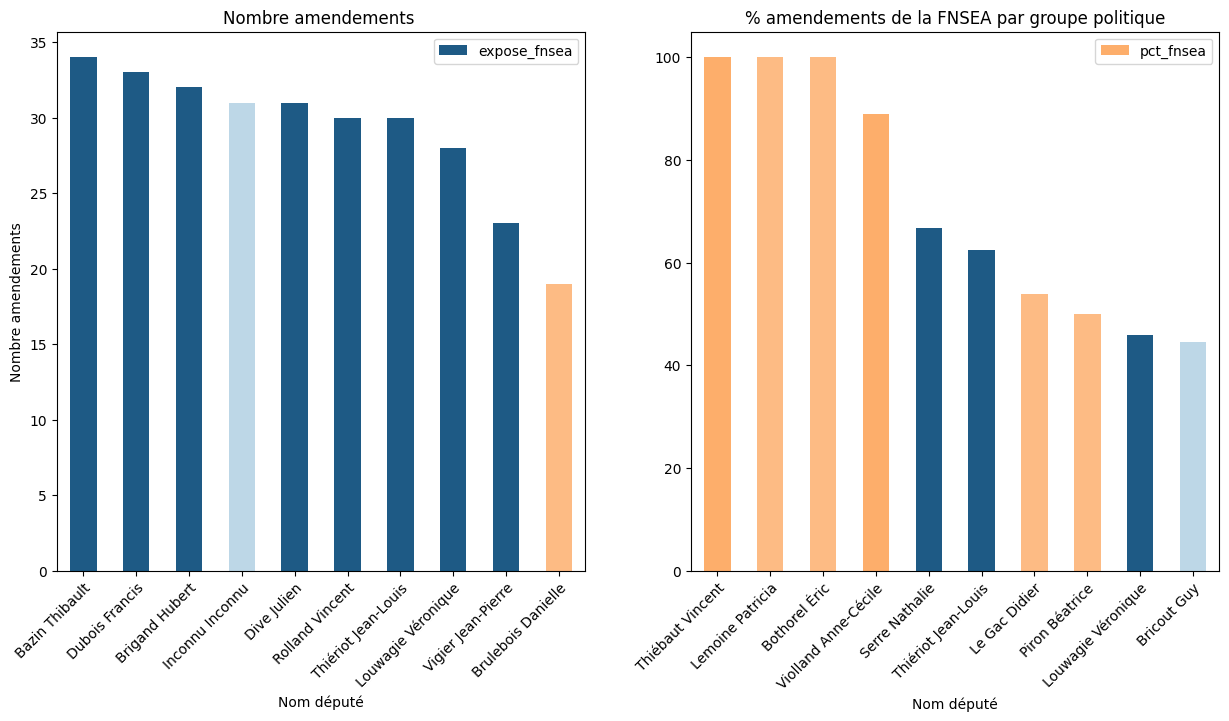

In [193]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

NUM_PLOT = 10
df = df_an.groupby(["acteur_ref","acteur_denom"]).agg({
    "expose_fnsea" : "sum",
    "color" : "max"
}).reset_index().sort_values("expose_fnsea",ascending=False).head(NUM_PLOT)

df.plot.bar(x='acteur_denom', y='expose_fnsea', rot=0, ax = axs[0], color=df.color.values)
axs[0].set_xticklabels(df.acteur_denom.head(NUM_PLOT), rotation=45, ha='right', rotation_mode='anchor')

axs[0].set_ylabel('Nombre amendements')
axs[0].set_xlabel('Nom député')
axs[0].set_title("Nombre amendements ");


NUM_PLOT = 10
df = df_an.groupby(["acteur_ref","acteur_denom"]).agg({
    "expose_fnsea" : "sum",
    "article" : "count",
    "color" : "max"
}).reset_index()

df["pct_fnsea"] = df["expose_fnsea"] * 100 /  df["article"] 

df = df.sort_values("pct_fnsea",ascending=False).head(NUM_PLOT)

df.plot.bar(x='acteur_denom', y='pct_fnsea', rot=0, ax = axs[1], color=df.color.values)
axs[1].set_xticklabels(df.acteur_denom.head(NUM_PLOT), rotation=45, ha='right', rotation_mode='anchor')

axs[1].set_title("% amendements de la FNSEA par groupe politique")
axs[1].set_xlabel('Nom député');

# Recherche par comparaison d'embeddings - SENAT

In [194]:
groupes_politiques_couleurs = {
    "Socialiste, Écologiste et Républicain": {
        "groupe_politique_nom": "Socialiste, Écologiste et Républicain",
        "couleur": "#fc9272"  # Rose clair
    },
    "Union Centriste": {
        "groupe_politique_nom": "Union Centriste",
        "couleur": "#66c2a5"  # Vert-bleu
    },
    "Les Républicains": {
        "groupe_politique_nom": "Les Républicains",
        "couleur": "#3182bd"  # Bleu
    },
    "Écologiste - Solidarité et Territoires": {
        "groupe_politique_nom": "Écologiste - Solidarité et Territoires",
        "couleur": "#33a02c"  # Vert
    },
    "Rassemblement Démocratique et Social Européen": {
        "groupe_politique_nom": "Rassemblement Démocratique et Social Européen",
        "couleur": "#fdbb84"  # Orange clair
    },
    "Communiste Républicain Citoyen et Écologiste - Kanaky": {
        "groupe_politique_nom": "Communiste Républicain Citoyen et Écologiste - Kanaky",
        "couleur": "#b2182b"  # Rouge foncé
    },
    "Inconnu": {
        "groupe_politique_nom": "Inconnu",
        "couleur": "#cccccc"  # Gris
    },
    "Les Indépendants - République et Territoires": {
        "groupe_politique_nom": "Les Indépendants - République et Territoires",
        "couleur": "#fdae6b"  # Orange
    },
    "groupe Les Républicains": {
        "groupe_politique_nom": "Les Républicains",
        "couleur": "#3182bd"  # Bleu
    },
    "Rassemblement des démocrates, progressistes et indépendants": {
        "groupe_politique_nom": "Rassemblement des démocrates, progressistes et indépendants",
        "couleur": "#fee391"  # Jaune clair
    },
    "et Territoires": {
        "groupe_politique_nom": "et Territoires",
        "couleur": "#999999"  # Gris foncé
    },
    "groupe Union Centriste": {
        "groupe_politique_nom": "Union Centriste",
        "couleur": "#66c2a5"  # Vert-bleu
    },
    "Sénateurs ne figurant sur la liste d'aucun groupe politique": {
        "groupe_politique_nom": "Non inscrit",
        "couleur": "#999999"  # Gris foncé
    },
    "Citoyen et Écologiste - Kanaky": {
        "groupe_politique_nom": "Citoyen et Écologiste - Kanaky",
        "couleur": "#b2182b"  # Rouge foncé
    }
}


In [195]:
df_senat_total = pd.read_csv("/Users/basileroth/Desktop/Code/offseason_greenlobby/data/processed/LOA/SENAT/df_senat.csv",index_col=0)
df_senat_total['new_groupe_politique'] = df_senat_total.groupe_politique.apply(lambda x : x.replace("\n"," ").replace("  "," ") \
                                    .replace("Membre du Groupe ","")\
                                    .replace("Membre du groupe ","")\
                                    .replace("Président du groupe ","") \
                                    .replace("Présidente du groupe ","") \
                                    .replace("Apparenté au groupe ","") \
                                    .replace("Rattachée au groupe ","") \
                                    .replace("Apparentée au groupe ","") \
                                    .replace("Rattaché au groupe ","") \
                                            if len(str(x)) > 3 else "Inconnu")

In [196]:
from offseason_greenlobby.config import gp_loa_senat

In [197]:
df_senat_total['color'] = df_senat_total['new_groupe_politique'].apply(lambda x : gp_loa_senat.get(x,{"couleur":"grey"}).get("couleur","grey"))

In [198]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle multilingue
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [199]:
df_fnsea["expose_embed"] = df_fnsea["exposé des motifs"].apply(lambda x : model.encode(x))
df_fnsea["dispositif_embed"] = df_fnsea["dispositif"].apply(lambda x : model.encode(x))

In [200]:
df_senat_total["expose_embed"] = df_senat_total["EXPOSE_SOMMAIRE"].apply(lambda x : model.encode(x))

In [201]:
THRESHOLD = 0.90

In [202]:
# CALCUL DU NOMBRE D'AMENDEMENTS DE L'ASSEMBLEE QUI CORRESPONDENT PAR RAPPORT À CEUX DE LA FNSEA
def get_list_amendements_exposé(article,exposé,THRESHOLD):
    exp_cpt = df_senat_total[df_senat_total['article'] == article].expose_embed.apply(lambda x : 1 if util.cos_sim(x, exposé)[0][0] > THRESHOLD else False)
    return exp_cpt.sum()


df_fnsea['expose_cpt_senat'] = df_fnsea.apply(lambda x: get_list_amendements_exposé(x['article concerné'], x["expose_embed"],  THRESHOLD), axis=1)
df_fnsea['expose_cpt_original_senat'] = df_fnsea.apply(lambda x: get_list_amendements_exposé(x['article original'], x["expose_embed"],  THRESHOLD), axis=1)

# Idées les plus reprises

In [203]:
bar_plot_df = df_fnsea.sort_values("expose_cpt_original_senat")["exposé des motifs"].head(10).values

bar_plot_df

array(['La formulation retenue dans l’article 1er du projet de loi qui affirme que « l’agriculture, la pêche etl’aquaculture sont d’intérêt général majeur » risque de transformer l’agriculture en bien publicpouvant justifier un droit de regard collectif sur les politiques agricoles.Par ailleurs, le second volet de l’article portant sur la souveraineté alimentaire qui reprend en partieles termes de l’actuel L. 1 du code rural et de la pêche maritime créé une confusion dans les prioritésdes politiques publiques. Cette perte de lisibilité législative conduira donc inévitablement à une totaleinefficacité des principes posés dans la loi.C’est la raison pour laquelle, le présent amendement qui traduit juridiquement la volonté politiquede rééquilibrer les intérêts agricoles et intérêts environnementaux vise à inscrire le principefondamental selon lequel la protection, la valorisation et le déploiement de l’agriculture sontreconnus d’intérêt général majeur et défendus au même titre que les aut

In [204]:
def get_cpt_per_amendement_exp(article,exposé,THRESHOLD):
    exp_cpt = df_fnsea[df_fnsea['article original'] == article].expose_embed.apply(lambda x : 1 if util.cos_sim(x, exposé)[0][0] > THRESHOLD else False)
    return 1 if exp_cpt.sum() > 0 else 0

df_senat_total['expose_fnsea'] = df_senat_total.apply(lambda x: get_cpt_per_amendement_exp(x['article'], x["expose_embed"], THRESHOLD), axis=1)

def get_cpt_per_amendement_exp_full(article,exposé,THRESHOLD):
    exp_cpt = df_fnsea[df_fnsea['article original'] == article].expose_embed.apply(lambda x : 1 if util.cos_sim(x, exposé)[0][0] > THRESHOLD else False)
    return exp_cpt.sum()

df_senat_total['expose_fnsea_full'] = df_senat_total.apply(lambda x: get_cpt_per_amendement_exp_full(x['article'], x["expose_embed"], THRESHOLD), axis=1)


# % Amendements co-rédigé par la FNSEA par article

In [205]:
an = df_senat_total.groupby(["article"]).agg({
    'expose_fnsea': 'sum' } ).reset_index().rename(columns={"article":"article concerné"})

fnsea = df_fnsea[["article original","num_amendements_art_an_part"]].groupby("article original").num_amendements_art_an_part.mean().reset_index()

for index,row in an.iterrows():
    fnsea.loc[fnsea["article original"] == row["article concerné"],"cpt"] = row["expose_fnsea"]

fnsea["pct_concerné"] = fnsea["cpt"] / fnsea["num_amendements_art_an_part"] * 100

In [206]:
fnsea

,article original,num_amendements_art_an_part,cpt,pct_concerné
0,1,731.25,2.0,0.273504
1,2,669.00,1.0,0.149477
2,5,206.00,0.0,0.000000
3,9,267.50,1.0,0.373832
4,10,150.80,5.0,3.315650
5,12,83.50,1.0,1.197605
6,13,68.00,0.0,0.000000
7,14,622.00,3.0,0.482315
8,16,9.00,10.0,111.111111
9,17,17.00,0.0,0.000000


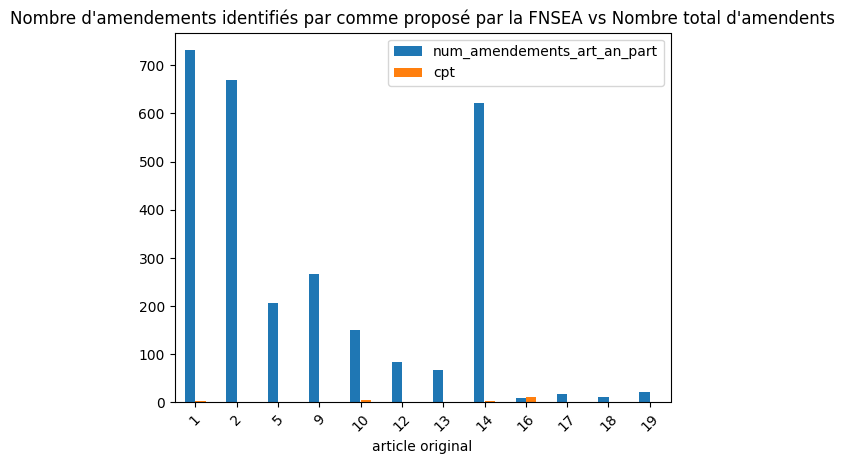

In [207]:
ax = fnsea.plot(x="article original", y=["num_amendements_art_an_part", "cpt"], kind="bar", rot=0)

plt.title("Nombre d'amendements identifiés par comme proposé par la FNSEA vs Nombre total d'amendents")
ax.set_xticklabels(fnsea["article original"], rotation=45)
fig.tight_layout()
plt.show();

# Nombre par GP et par député

In [208]:
df_senat_total.head()

,Nature,NOM_AMENDEMENT,Subdivision,Alinéa,auteur,Au nom de,Date de dépôt,Dispositif,Objet,Sort,...,article,IDEES,DESCRIPTION,CHAMBRE,groupe_politique,new_groupe_politique,color,expose_embed,expose_fnsea,expose_fnsea_full
0,Amt,1 rect. ter,art. add. après Article 12 bis,,Mme DUMONT,NaN,2025-02-04,"<body><p style=""text-align: justify;"">Apr&#232...","<body><p style=""text-align: justify;"">Le pr&#2...",Retiré,...,12,droit à l'erreur des agriculteurs,L’exercice agricole est soumis à un trop grand...,SENAT,Membre du groupe\nLes Républicains,Les Républicains,#1e5a85,"[0.114587605, 0.021279182, 0.01318722, 0.07928...",0,0
1,Amt,2 rect. ter,art. add. après Article 13,,M. Daniel LAURENT,NaN,2025-02-04,<body><p>Apr&#232;s l&#8217;article&#160;13</p...,"<body><p style=""text-align: justify;"">Depuis p...",Retiré,...,13,droit à l'erreur des agriculteurs,L’exercice agricole est soumis à un trop grand...,SENAT,Membre du groupe\nLes Républicains,Les Républicains,#1e5a85,"[-0.0074799825, -0.024058148, -0.005702963, 0....",0,0
2,Amt,3 rect. bis,art. add. après Article 18,,M. Jean-Michel ARNAUD,NaN,2025-02-04,"<body><p style=""text-align: justify;"">Apr&#232...","<body><p style=""text-align: justify;"">Le pr&#2...",Adopté,...,18,droit à l'erreur des agriculteurs,L’exercice agricole est soumis à un trop grand...,SENAT,Membre du groupe\nUnion Centriste,Union Centriste,#66c2a5,"[-0.012370724, 0.095983, 0.039557762, -0.00916...",0,0
3,Amt,4 rect. ter,Article 14,14,M. CAMBIER,NaN,2025-02-04,"<body><p style=""text-align: justify;"">Apr&#232...","<body><div><p style=""text-align: justify;"">On ...",Retiré,...,14,droit à l'erreur des agriculteurs,L’exercice agricole est soumis à un trop grand...,SENAT,Membre du groupe\nUnion Centriste,Union Centriste,#66c2a5,"[0.0017470499, -0.00835058, 0.16543432, 0.0658...",0,0
5,Amt,6 rect. quater,Article 1er quater,3,Mme ROMAGNY,NaN,2025-02-04,<body><p>Apr&#232;s l'alin&#233;a 3</p><p>Ins&...,"<body><p style=""text-align: justify;"">Dans la ...",Non soutenu,...,1,droit à l'erreur des agriculteurs,L’exercice agricole est soumis à un trop grand...,SENAT,Membre du groupe\nUnion Centriste,Union Centriste,#66c2a5,"[-0.11012664, 0.0717825, -0.032068357, -0.0855...",0,0


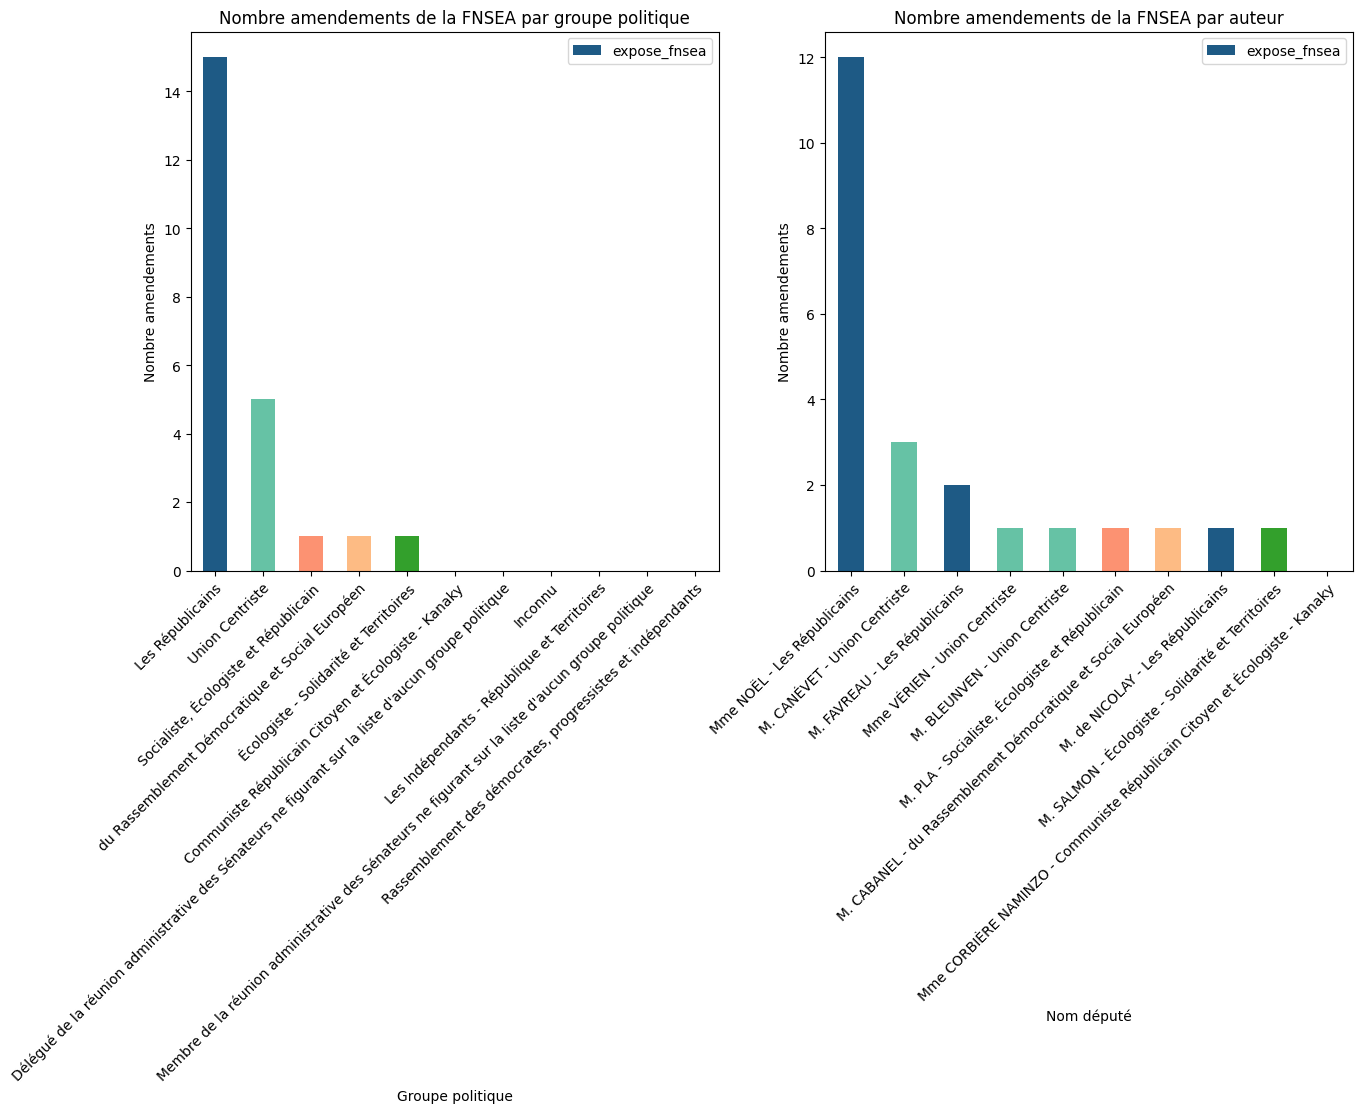

In [209]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

df = df_senat_total.groupby(["new_groupe_politique"]).agg({
    "expose_fnsea" : "sum",
    "color":"min"
}).reset_index().sort_values("expose_fnsea",ascending=False)

df.plot.bar(x='new_groupe_politique', y='expose_fnsea', rot=0, ax = axs[0],color=df.color)
axs[0].set_xticklabels(df.new_groupe_politique, rotation=45, ha='right', rotation_mode='anchor')
axs[0].set_title("Nombre amendements de la FNSEA par groupe politique");
axs[0].set_xlabel("Groupe politique");
axs[0].set_ylabel("Nombre amendements");


NUM_PLOT = 10
df = df_senat_total.groupby(["auteur","new_groupe_politique"]).agg({
    "expose_fnsea" : "sum",
    "color" : "max"
}).reset_index().sort_values("expose_fnsea",ascending=False).head(NUM_PLOT)

df["acteur_t"] = df.auteur + " - " + df.new_groupe_politique

df.plot.bar(x='auteur', y='expose_fnsea', rot=0, ax = axs[1],color=df.color)
axs[1].set_xticklabels(df.acteur_t.head(NUM_PLOT), rotation=45, ha='right', rotation_mode='anchor')

axs[1].set_ylabel('Nombre amendements')
axs[1].set_xlabel('Nom député')
axs[1].set_title("Nombre amendements de la FNSEA par auteur");


# % Par GP et par député

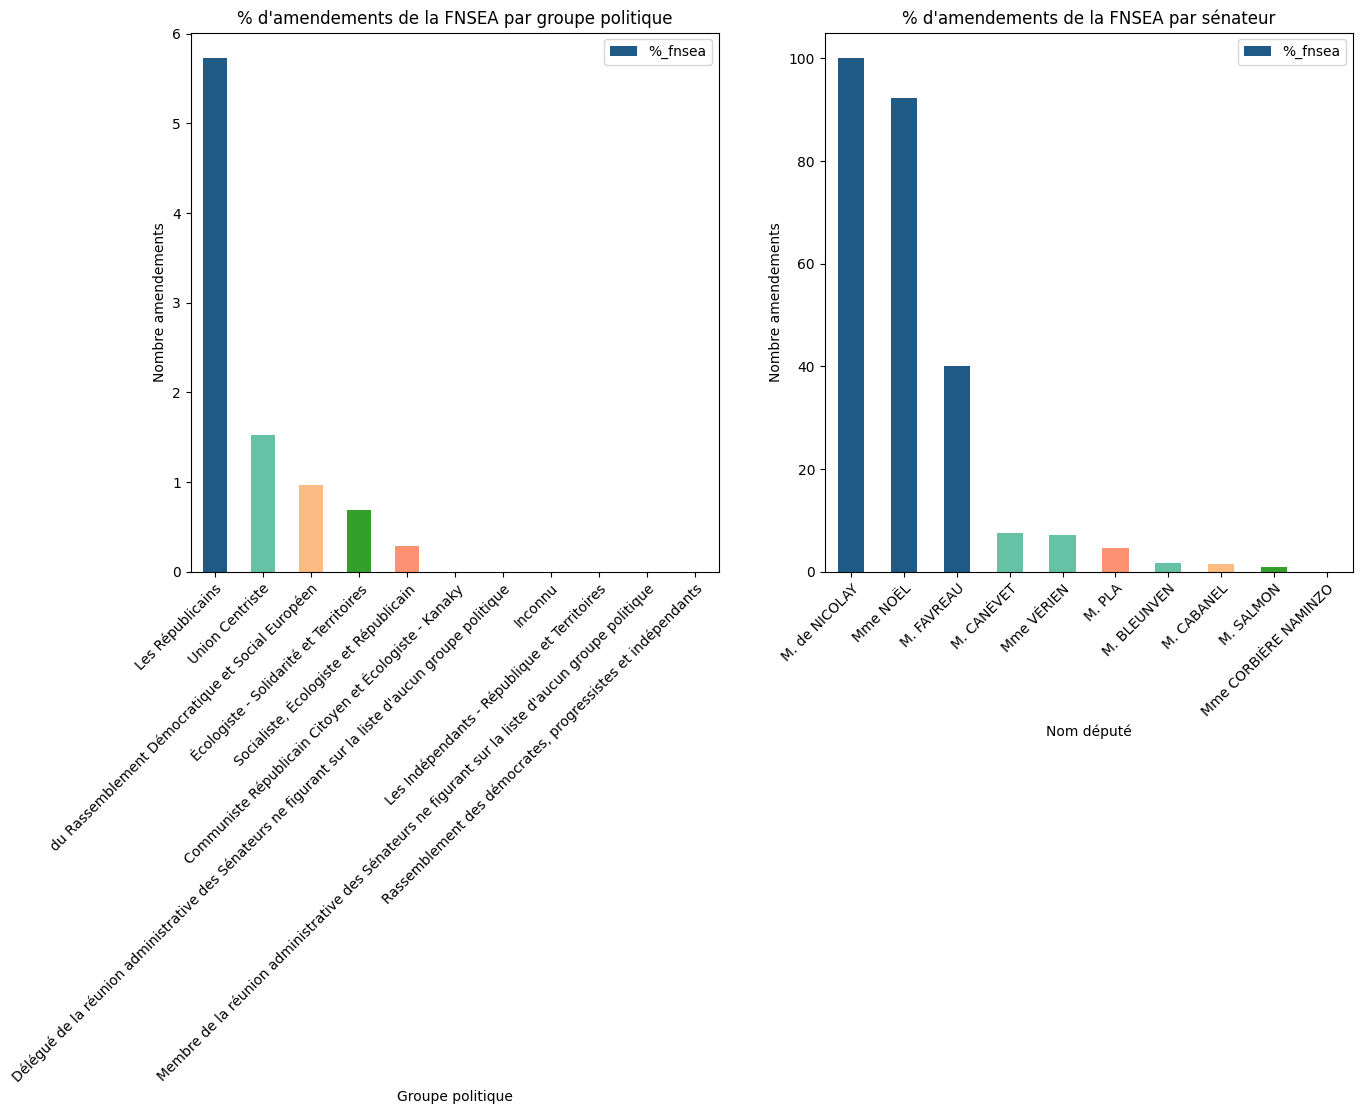

In [210]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

df = df_senat_total.groupby(["new_groupe_politique"]).agg({
    "expose_fnsea" : "sum",
    "EXPOSE_SOMMAIRE" : "count",
        "color":"min"

}).reset_index()

df["%_fnsea"] = df["expose_fnsea"] / df["EXPOSE_SOMMAIRE"] * 100

df = df.sort_values("%_fnsea",ascending=False)

df.plot.bar(x='new_groupe_politique', y='%_fnsea', rot=0, ax = axs[0],color=df.color)
axs[0].set_xticklabels(df.new_groupe_politique, rotation=45, ha='right', rotation_mode='anchor')
axs[0].set_title("% d'amendements de la FNSEA par groupe politique");
axs[0].set_xlabel("Groupe politique");
axs[0].set_ylabel("Nombre amendements");


NUM_PLOT = 10
df = df_senat_total.groupby(["auteur"]).agg({
    "expose_fnsea" : "sum",
    "EXPOSE_SOMMAIRE" : "count",
        "color":"min"

}).reset_index()

df["%_fnsea"] = df["expose_fnsea"] / df["EXPOSE_SOMMAIRE"] * 100

df = df.sort_values("%_fnsea",ascending=False).head(NUM_PLOT)


df.plot.bar(x='auteur', y='%_fnsea', rot=0, ax = axs[1],color=df.color)
axs[1].set_xticklabels(df.auteur.head(NUM_PLOT), rotation=45, ha='right', rotation_mode='anchor')

axs[1].set_ylabel('Nombre amendements')
axs[1].set_xlabel('Nom député')
axs[1].set_title("% d'amendements de la FNSEA par sénateur");
